# Choose a Car Profitably [Car Price prediction] PART.2

This work has made by Paul Krivchenia in cooperation with Vitaliy Burlakov (a.k.a Vetak8):
#### [My GitHub](https://github.com/Paull-dark)
#### [Vetak's GitHub](https://github.com/vetak8)
#### [Vetak's Kaggle](https://www.kaggle.com/vitaliyburlakov)

<img src = 'http://3.bp.blogspot.com/--knDCWYzMOw/UqzpwyctJeI/AAAAAAAAAT8/Ui66KNd1nXM/s1600/7egylh57hbhs.jpg' width= '400px'>

<a id="sec2"></a>
# [INDEX](#sec2)

<a id="sec1"></a>
1. [Description](#sec1)
   * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)

<a id="sec2"></a>
# [Import LIBRARIES](#sec2)

In [1]:
from Preprocessing import df_combined

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from jupyterthemes import jtplot

from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud  # for creating cloud of words
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRFRegressor


warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

body_type
brand
color
complectation_dict
description
engine_displacement
engine_power
equipment_dict
fuel_type
image
mileage
model_date
model_info
model_name
name
doors_count
price_currency
production_date
sell_id
super_gen
vehicle_configuration
vehicle_transmission
vendor
owner_count
owning_period
car_passport
wheel_drive
wheel_location
condition
custom
price
sample


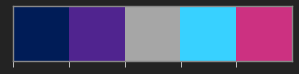

In [2]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [FUNCTIONS and CLASSES](#sec4)
[(INDEX)](#sec2)

<a id="sec4"></a>
## [GENERAL FUNCTIONS](#sec4)
[(INDEX)](#sec2)

In [3]:
def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [4]:
def get_variable_distribution(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
#     sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)
    sns.boxplot(col.values,color=colors[3])

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')

    plt.show()

In [5]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
    #     sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [6]:
def cleanTxt(text):
    '''Function is called for cleaning text from trash
    INPUT: dirty string
    OUTPUT: More or less clean string'''

    text = re.sub(r'@[А-Яа-я0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub('^а-яА-Я', ' ', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = re.sub(r'👍🏻', '', text)
    # there are much more emoji. I don't know how to identify them so far

    text = text.lower()
    text = text.strip()
    #text = text.split()
    return text

In [7]:
def to_log(df, cols_to_log):
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

In [8]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [9]:
def get_regression_metrics(report_df, model, X_test, y_test, name):
    '''Create and add metrics into a pandas DF after experiment'''

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_test,model.predict(X_test))
    except:
        report['MAPE'] = 'Fuck'
    report['MAE'] = mean_absolute_error(y_test, model.predict(X_test))
    report['MSE'] = mean_squared_error(y_test, model.predict(X_test))
    report['RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

<a id="sec4"></a>
## [Classes](#sec4)
[(INDEX)](#sec2)

In [10]:
class Encoder():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [11]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

    def get_dbscan_outliers(self, column1, column2, dbscan_eps,
                            dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter(self.df,
                   x=scale_column1,
                   y=scale_column2,
                   color=clustering.labels_,
                   size=column2)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')
        fig.update_xaxes(title=(f'{column1}'))
        fig.update_yaxes(title=(f'{column2}'))
        fig.update_layout(width = 700)
        fig.update_layout(height = 600)
        
        fig.show()
        #         sns.scatterplot(scale_column1, scale_column2,
        #                         hue=clustering.labels_, alpha=0.5)
        #         plt.title('CLUSTERS\n', fontsize=15)
        #         plt.xlabel(f'{column1}')
        #         plt.ylabel(f'{column2}')
        return df_temp[df_temp["cluster"] == cluster_num].index

<a id="sec4"></a>
## [FUNCTIONS FOR FEATURE ENGINEERING](#sec4)
[(INDEX)](#sec2)

In [12]:
def get_tax_category(engine_power):
    '''Function breaks down the number of horse
    power by taxation category in Russia'''

    if engine_power <= 100:
        return int(1)
    elif 100 < engine_power <= 150:
        return int(2)
    elif 150 < engine_power <= 200:
        return int(3)
    elif 200 < engine_power <= 250:
        return int(4)
    elif engine_power > 250:
        return int(5)


def get_low_registr(word):
    '''Get lowercase for string'''
    try:
        return word.lower()
    except:
        return None
    
def get_i3_displacement(engine_displacement, fuel_type, model_name):
    '''fill mising values for  BMW i3'''
    
    if model_name == 'i3':
        if fuel_type == 'гибрид':
            return 0.7
        else:
            return 0
    else:
        return engine_displacement

def get_electro_displacement(engine_displacement, fuel_type):
    '''Filling mising vars for electrocars'''
    
    if fuel_type == 'электро':
        return 0
    else:
        return engine_displacement
    
def get_acceleration(string):
    '''Function extracting acceleration'''
    
    try:
        return float(re.split(',', re.split('acceleration\W+', str(string))[1])[0])
    except:
        return None
    
def get_fuel_rate(string):
    '''Extrating fuel rate'''
    try:
        return float(re.split(',', re.split('fuel_rate\W+', str(string))[1])[0])

    except:
        return None

<a id="sec5"></a>
# [5.Load and Chek the Dataset](#sec5)
[(INDEX)](#sec2)

In [13]:
# import data pre-processed data set
df = df_combined.copy()
df.sample(2)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample
42381,внедорожник 5 дв,BMW,белый,{'id': '0'},Официальный дилерский центр РОЛЬФ Сити | Автом...,3.0,249.0,"{'cruise-control': True, 'asr': True, 'usb': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/198435...,95047,2014,"{'code': 'X6', 'name': 'X6', 'ru_name': 'Х6', ...",X6,30d 3.0d AT (249 л.с.) 4WD,5,RUB,2018,1103001587,"{'id': '20158772', 'name': '30d', 'nameplate':...",useless_col,AUTOMATIC,EUROPEAN,1,NaN,ORIGINAL,полный,LEFT,True,True,3816000.0,1
114791,пикап двойная кабина,Mitsubishi,чёрный,{'id': '0'},Mitsubishi l200 номер 1 среди пикапов в РФ. Пр...,2.4,154.0,"{'engine-proof': True, 'cruise-control': True,...",дизель,//avatars.mds.yandex.net/get-autoru-vos/492846...,185000,2015,"{'code': 'L200', 'name': 'L200', 'ru_name': 'Л...",L200,2.4d AT (154 л.с.) 4WD,4,RUB,2015,1103497180,"{'id': '20680649', 'displacement': 2442, 'engi...",useless_col,AUTOMATIC,JAPANESE,2,NaN,ORIGINAL,полный,LEFT,True,True,1550000.0,1


<a id="sec6"></a>
# [9.FETAURE ENGINEERING](#sec6)
[(INDEX)](#sec2)

Get lowercase

In [14]:
# take cols with objects
object_columns = df.dtypes[df.dtypes.values == object].index.to_list()

for col in object_columns:
    df[col] = df[col].apply(lambda string: get_low_registr(string))

<a id="sec6"></a>
## [Target](#sec6)
[(INDEX)](#sec2)

Drop rows with car price more than 30 mlns.

In [15]:
idx_to_drop = list(df[df['price'] >= 30000000].index)
df=df.drop(idx_to_drop)

Drop rows with missing values

In [16]:
df.query('sample == 1')['price'].isna().sum()

624

In [17]:
indexes_to_drop = df[(df['price'].isna()) & (df['sample']==1)].index
df = df.drop(indexes_to_drop)

<a id="sec6"></a>
## [body_type](#sec6)
[(INDEX)](#sec2)

Reduce quantity of body_types

In [18]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df['body_type']:
    new_column.append(pattern.match(str(string))[0])
df['body_type'] = new_column

In [19]:
# Create list with top colors
top_colors = df['body_type'].value_counts()[df['body_type'].value_counts(
) > np.percentile((df['body_type'].value_counts().values), 70)].index.tolist()

#take all colors from df to a list
all_colors = df['body_type'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['body_type'].isin(colors_to_drop), 'body_type'] = 'other'

In [20]:
df['body_type'].value_counts()

седан          66648
внедорожник    63983
хэтчбек        16791
other          14990
лифтбек         9291
универсал       7030
Name: body_type, dtype: int64

<a id="sec6"></a>
## [color](#sec6)
[(INDEX)](#sec2)

With a reference to EDA section we generate new feature to show whether the color is popular.

Meanwhile we re-orgasnize colors in original column by taking only most common colors

In [21]:
# List of top3 colors (see EDA)
popular_color = ['чёрный', 'белый', 'серый']
df['popular_color'] = df['color'].apply(
    lambda color: 1 if color in popular_color else 0)

In [22]:
# Create list with top colors
top_colors = df['color'].value_counts()[df['color'].value_counts(
) > np.percentile((df['color'].value_counts().values), 70)].index.tolist()

#take all colors from df to a list
all_colors = df['color'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['color'].isin(colors_to_drop), 'color'] = 'other'

<a id="sec6"></a>
## [Model_name](#sec6)
[(INDEX)](#sec2)

<a id="sec6"></a>
## [Description](#sec6)
[(INDEX)](#sec2)

Let's generate new features:
- Sensitivity and polarity for the description column

In [23]:
df['description'] = df['description'].fillna('none')
df['description'] = df['description'].apply(cleanTxt)

In [24]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [25]:
# %%script false
# Create new cols and call the func

df['subjectivity'] = df['description'].apply(get_subjectivity)

df['polarity'] = df['description'].apply(get_polarity)


In [26]:
# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [27]:
# %%script false
df['analysis'] = df['polarity'].apply(get_analysis)

In [28]:
# show data
df.sample(4)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample,popular_color,subjectivity,polarity,analysis
43409,внедорожник,bmw,чёрный,{'id': '0'},вложений не требуется . возможно продажа в кре...,2.0,150.0,"{'electro-window-back': true, 'tinted-glass': ...",бензин,//avatars.mds.yandex.net/get-autoru-vos/445910...,97000,2012,"{'code': 'x1', 'name': 'x1', 'ru_name': 'х1', ...",x1,18i 2.0 at (150 л.с.),5,rub,2013,1103225492,"{'id': '8247065', 'name': '18i', 'nameplate': ...",useless_col,automatic,european,3,"{'year': 2020, 'month': 11}",duplicate,задний,left,None,None,840000.0,1,1,0.0,0.0,neutral
93049,внедорожник,toyota,белый,{'id': '0'},"● автокредит от 2,9%● первоначальный взнос от ...",3.5,249.0,"{'cruise-control': true, 'electro-window-back'...",бензин,//avatars.mds.yandex.net/get-autoru-vos/476234...,128000,2013,"{'code': 'highlander', 'name': 'highlander', '...",highlander,3.5 at (249 л.с.) 4wd,5,rub,2014,1103514185,"{'id': '20082325', 'displacement': 3456, 'engi...",useless_col,automatic,japanese,1,None,original,полный,left,None,None,2300000.0,1,1,0.0,0.0,neutral
23052,внедорожник,lexus,чёрный,None,"нормальное состояние. пробег реальный, по сиде...",3.0,201.0,None,бензин,https://autoru.naydex.net/imflt9272/520f62i9/2...,427000,1997,"{""code"":""rx"",""name"":""rx"",""ru_name"":""rx"",""morph...",rx,300 3.0 at (201 л.с.) 4wd,5,rub,2001,1099900048,"{""id"":""6422903"",""name"":""300"",""nameplate"":""300""...",allroad_5_doors automatic 3.0,automatic,japanese,3,None,duplicate,полный,left,не требует ремонта,растаможен,NaN,0,1,0.0,0.0,neutral
176212,внедорожник,mazda,чёрный,"{'id': '20069158', 'name': 'supreme', 'availab...",- автомобиль куплен в декабре 2013 года- один ...,2.5,192.0,"{'cruise-control': true, 'tinted-glass': true,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/425615...,169000,2011,"{'code': 'cx_5', 'name': 'cx-5', 'ru_name': 'c...",cx_5,2.5 at (192 л.с.) 4wd,5,rub,2013,1103657569,"{'id': '9280918', 'displacement': 2488, 'engin...",useless_col,automatic,japanese,1,"{'year': 2013, 'month': 12}",original,полный,left,None,None,1390000.0,1,1,0.0,0.0,neutral


<a id="sec6"></a>
## [fuel_type](#sec6)
[(INDEX)](#sec2)

In [29]:
# lets strip fuel type
df['fuel_type'] = df.fuel_type.apply(lambda fuel: str(fuel).strip())

<a id="sec6"></a>
## [engine_displacement](#sec6)
[(INDEX)](#sec2)

We know, that there is no engine displacement for the electical cars. We also know there is missing values in this colums.

Let's fix it. If car is electric - diplacement shall be 0.

In [30]:
df['engine_displacement'] = df[['engine_displacement','fuel_type']].apply(
    lambda x: get_electro_displacement(*x), axis=1)

It was observed that BMW model i3 has missing values in engine displacement. Let's say if it it is hybrid - then eng_displ - 0.7. If n0 - then 0

In [31]:
df['engine_displacement'] = df[['engine_displacement','fuel_type', 'model_name']].apply(
    lambda x: get_i3_displacement(*x), axis=1)

<a id="sec6"></a>
## [engine_power](#sec6)
[(INDEX)](#sec2)

There is a special low in Russian Federation that devide cars by tax categories. 

More power in engine, higer grade of tax. It may impact on a prediction. Let's break our cars down by such categories

In [32]:
df['tax_rate'] = df['engine_power'].apply(
    lambda engine_power: get_tax_category(engine_power)).astype('category')

<a id="sec6"></a>
## [Super_gen](#sec6)
[(INDEX)](#sec2)

Let's extract some information like an acceleration from supergen column.

Generated new feature Acceleration

In [33]:
# Before we do, fill up empty dictionaries with 'Nan'
df['super_gen'] = df['super_gen'].fillna('NaN')
df['super_gen'] = df['super_gen'].apply(cleanTxt)
# Extract fuel rate,acceleration and generate new feature
df['acceleration'] = df['super_gen'].apply(lambda string:get_acceleration(string))
df['fuel_rate'] = df['super_gen'].apply(lambda string:get_fuel_rate(string))

In [34]:
# missing vars in a new feature
df['acceleration'].isna().sum()

11243

In [35]:
df['fuel_rate'].isna().sum()

21408

Let's fill missing values by randomly choosen value from most common in particular colums.

For a company, add car pasport here and owner count

In [36]:
cols_to_fill = ['acceleration', 'fuel_rate', 'car_passport','owner_count']
for col in cols_to_fill:
    missing_vars(df,col)

<a id="sec6"></a>
## [Transmission](#sec6)
[(INDEX)](#sec2)

<a id="sec6"></a>
## [Price change index ](#sec6)
[(INDEX)](#sec2)

With a reference to EDA, we know, that some brands loose their price more faster than others. Let's generate such feature

In [37]:
def get_change_index(model):
    if model == 'ford':
        return int(1)
    if model == 'volvo' or model == 'mercedes-benz':
        return int(2)
    if model == 'honda' or model == 'audi':
        return int(2)
    return int(0)

In [38]:
df['prc_chg_idx'] = df['brand'].apply(
    lambda brand: get_change_index(brand)).astype('category')

<a id="sec6"></a>
## [Dropping cars without info out](#sec6)
[(INDEX)](#sec2)

In [39]:
df['engine_displacement'].isna().sum()

3

In [40]:
df = df.dropna(axis=0, subset=['engine_displacement'])

<a id="sec6"></a>
## [Handling multicollinearity out](#sec6)
[(INDEX)](#sec2)

In [41]:
# extract trhee columns from dataset, which are correlated
data = df[['mileage', 'model_date','production_date']].values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_1'],df['pca_2'] = pca_data[:,0],pca_data[:,1]
# df = df.drop(['model_date','mileage'],axis=1)

<a id="sec6"></a>
## [Clustering](#sec6)
[(INDEX)](#sec2)

In [42]:
cluster = Outliers_detector(df)

In [43]:
# indeces = cluster.get_dbscan_outliers('model_date', 'mileage', dbscan_eps=.3,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

<a id="sec6"></a>
## [Logarithm](#sec6)
[(INDEX)](#sec2)

In [44]:
cols_to_log = [
    'engine_displacement',
    'production_date',
    'pca_1', 'pca_2',
    'engine_power',
    'mileage',
    'model_date',
    'acceleration',
    'fuel_rate',
]

df = to_log(df, cols_to_log)

<a id="sec6"></a>
## [ENCODING](#sec6)
[(INDEX)](#sec2)

In [45]:
# Re-set indeces
df.reset_index(drop=True, inplace=True)

In [46]:
# Save un-encoded df
df_cat = df.copy()

In [47]:
encoder = Encoder(df)

In [48]:
to_hot = [
    'body_type',
    'brand',
    'color',
    'fuel_type',    
    'doors_count',
    'vehicle_transmission',
    'vendor',
    'wheel_drive',
    'tax_rate',
    'analysis',
    'owner_count',
    ]

to_label = ['car_passport', 'wheel_location','prc_chg_idx']

In [49]:
#%%script false
for col in to_hot:
    df = encoder.hot_encoder(col)

In [50]:
for col in to_label:
    encoder.label_encoder(col)

<a id="sec6"></a>
## [DROP COLS OUT](#sec6)
[(INDEX)](#sec2)

In [51]:
cols_to_drop = [
    'complectation_dict',
    'description',
    'equipment_dict',
    'image',
    'model_info',
    'name',
    'price_currency',
    'vehicle_configuration',
    'custom',
    'condition',
    'owning_period',
    'super_gen', 'sell_id',
    'model_name',
    'engine_power',
    'mileage', # have PCA instead
    'model_date', # have PCA instead
    'production_date' # have PCA instead
]
df = df.drop(cols_to_drop, axis=1)

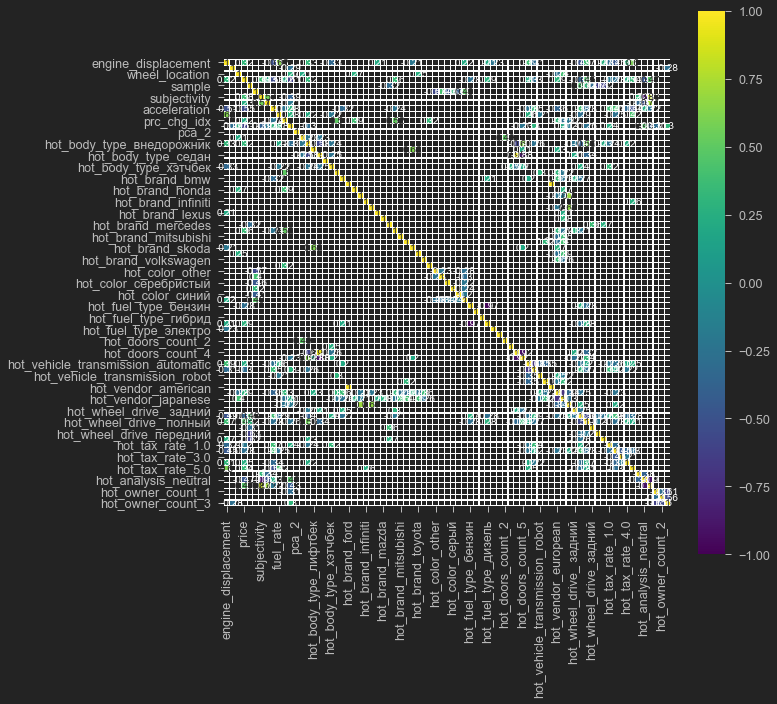

In [52]:
corr_matrix(df, det=False)

engine_displacement - 0%
car_passport - 0%
wheel_location - 0%
price - 19%
sample - 0%
popular_color - 0%
subjectivity - 0%
polarity - 0%
acceleration - 0%
fuel_rate - 0%
prc_chg_idx - 0%
pca_1 - 0%
pca_2 - 0%
hot_body_type_other - 0%
hot_body_type_внедорожник - 0%
hot_body_type_лифтбек - 0%
hot_body_type_седан - 0%
hot_body_type_универсал - 0%
hot_body_type_хэтчбек - 0%
hot_brand_audi - 0%
hot_brand_bmw - 0%
hot_brand_ford - 0%
hot_brand_honda - 0%
hot_brand_hyundai - 0%
hot_brand_infiniti - 0%
hot_brand_kia - 0%
hot_brand_lexus - 0%
hot_brand_mazda - 0%
hot_brand_mercedes - 0%
hot_brand_mercedes-benz - 0%
hot_brand_mitsubishi - 0%
hot_brand_nissan - 0%
hot_brand_skoda - 0%
hot_brand_toyota - 0%
hot_brand_volkswagen - 0%
hot_brand_volvo - 0%
hot_color_other - 0%
hot_color_белый - 0%
hot_color_серебристый - 0%
hot_color_серый - 0%
hot_color_синий - 0%
hot_color_чёрный - 0%
hot_fuel_type_бензин - 0%
hot_fuel_type_газ - 0%
hot_fuel_type_гибрид - 0%
hot_fuel_type_дизель - 0%
hot_fuel_type

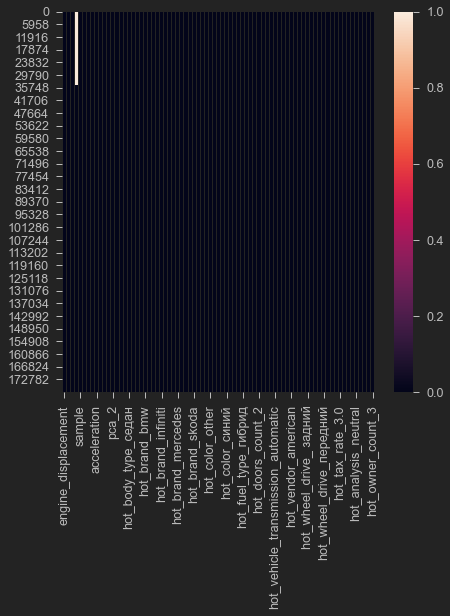

In [53]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(df[cols].isnull()) 

# Show in percents
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

<a id="sec6"></a>
## [Scaling](#sec6)
[(INDEX)](#sec2)

In [54]:
# Extract the part of dataframe for testing
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_valid = df.query('sample == 0').drop(['sample'], axis=1)

# Extract data and label
X = df_train.drop(['price'], axis=1)
y = df_train[['price']]

# Extract data for validation
X_valid = df_valid.drop(['price'], axis=1)

In [55]:
cols_to_scal = [
    'engine_displacement', 'subjectivity', 
    'polarity', 'acceleration',
    'fuel_rate', 'pca_1', 'pca_2'
]

In [56]:
scaler = RobustScaler()
X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
X_valid[cols_to_scal] = scaler.transform(X_valid[cols_to_scal])

In [57]:
print(
    f'Shape of X_train:{X.shape} \nShape of X_Valid:{X_valid.shape} \nShape of Target:{y.shape} '
)

Shape of X_train:(144044, 75) 
Shape of X_Valid:(34686, 75) 
Shape of Target:(144044, 1) 


<a id="sec6"></a>
# [9.Models](#sec6)
[(INDEX)](#sec2)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=42)

In [59]:
from lazypredict.Supervised import LazyRegressor

In [60]:
%%script false
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)

Couldn't find program: 'false'


In [61]:
%%script false
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

Couldn't find program: 'false'


In [62]:
%%script false
models

Couldn't find program: 'false'


<a id="sec6"></a>
## [EXTRA-TREE](#sec6)
[(INDEX)](#sec2)

In [63]:
%%script false
# Training and evaluating Random Forest
rf = ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Couldn't find program: 'false'


In [64]:
df_report = pd.DataFrame(data=None)

In [65]:
%%script false
df_report = get_regression_metrics(df_report, rf, X_test,
                       y_test, 'Extream_tree_BaseLine')

Couldn't find program: 'false'


In [66]:
%%script false
df_report

Couldn't find program: 'false'


In [67]:
df_f = df.copy()

In [68]:
# Extract the part of dataframe for testing
df_train_1 = df_f.query('sample == 1').drop(['sample'], axis=1)
df_valid_1 = df_f.query('sample == 0').drop(['sample'], axis=1)

In [69]:
# Extract data and label
X = df_train_1.drop(['price'], axis=1)
y = df_train_1[['price']]
scaler = RobustScaler()
X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])


In [70]:
# extract trhee columns from dataset, which are correlated
data = X.values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=25)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

# df['pca_1'],df['pca_2'] = pca_data[:,0],pca_data[:,1]
# df = df.drop(['model_date','mileage'],axis=1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    pca_data, y, shuffle=True, random_state=42)

In [72]:
# Training and evaluating Random Forest
rf = ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(X_train, np.log(y_train))
# y_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.5s finished


ExtraTreesRegressor(bootstrap=True, n_estimators=300, n_jobs=-1,
                    random_state=42, verbose=1)

In [76]:
#%%script false
score = mape(y_test,np.expm1(rf.predict(X_test)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished


MemoryError: Unable to allocate 9.66 GiB for an array with shape (36011, 36011) and data type float64

In [77]:
predict = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished


In [82]:
predicted=np.expm1(predict)

In [81]:
real=y_test.values

In [83]:
np.abs(real-predicted/real)

MemoryError: Unable to allocate 9.66 GiB for an array with shape (36011, 36011) and data type float64

In [ ]:
%%script false
df_report = get_regression_metrics(df_report, rf, X_test,
                       y_test, 'Extream_tree_PCA')

In [ ]:
df_report